## Imports and constants

In [638]:
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold

%matplotlib inline

In [639]:
name = "Transmission"
analysis_number = None
identifier = None

In [641]:
def average_error(error_array):
    try:
        error = np.div(1, np.sum(np.divide(1, np.power(error_array, 2))))
    except ZeroDivisionError:
        error = 0
    return error

def weight_average(data_array, error_array, bin_indices):
    assert len(data_array) == len(bin_indices) and len(data_array) == len(error_array), "Arrays should be same length."
    try:
        mean = np.div(np.sum(np.divide(data_array,np.power(error_array, 2)),
                      np.sum(np.divide(1, np.power(error_array, 2)))))
    except ZeroDivisionError:
        error = 0
    return error

In [642]:
class TransmissionRun:
    """ A class that processes raw data for a transmission run.

    Instance attributes:
        - 
        - 
    """
    
    def __init__(self, data_and_header, frequency_jump_threshold_GHz=0.1):
        self._data, self._header = data_and_header
        self._average_datapoints()
        self._get_valid_frequency_range()
        self._filter_frequency_jumps(frequency_jump_threshold_GHz)

    def _average_datapoints(self):
        self.time = self._data["times"]
        self.frequency_GHz = self._data["frequency_after_GHz"]
        self.V_transmission = np.average(self._data["V_transmission"], axis=1)
        self.V_transmission_err = np.divide(np.std(self._data["V_transmission"], axis=1, ddof=1),
                                            np.sqrt(len(self._data["V_transmission"][0])))
        self.V_monitor = np.average(self._data["V_monitor"], axis=1)
        self.V_monitor_err = np.divide(np.std(self._data["V_monitor"], axis=1, ddof=1),
                                       np.sqrt(len(self._data["V_monitor"][0])))
        self.V_ratio = self.V_transmission / self.V_monitor
        self.V_ratio_err = np.multiply(self.V_ratio, np.sqrt(
            np.power(np.divide(self.V_monitor_err, self.V_monitor), 2) 
            + np.power(np.divide(self.V_transmission_err, self.V_transmission), 2)))

    def _get_valid_frequency_range(self):
        self.valid_freq_mask = self.frequency_GHz > 0
        valid_freqs = self.frequency_GHz[self.valid_freq_mask]
        self.valid_frequency_range_GHz = (np.min(valid_freqs), np.max(valid_freqs))

    def _filter_frequency_jumps(self, frequency_jump_threshold_GHz):
        freq_differences = np.abs(np.ediff1d(self.frequency_GHz))
        below_threshold_next = freq_differences < frequency_jump_threshold_GHz
        below_threshold_previous = np.roll(below_threshold_next, shift=1)
        mask = np.bitwise_and(below_threshold_next, below_threshold_previous)
        mask = np.append(mask, False)
        mask[0] = False
        self.frequency_jump_mask = np.bitwise_and(mask, self.valid_freq_mask)
    
    def bin_data(self, bin_width_GHz = 5):
        mask = self.frequency_jump_mask
        num_bins = int((self.valid_frequency_range_GHz[1] - self.valid_frequency_range_GHz[0]) / bin_width_GHz)

        if num_bins == 0:
            num_bins = 1
        
        bins = np.linspace(
            self.valid_frequency_range_GHz[0], 
            self.valid_frequency_range_GHz[1], 
            num_bins, endpoint = True
        )
        
        bin_index = np.digitize(self.frequency_GHz[mask], bins)
        for kk in range(len(bins) + 1):
            mask1 = bin_index == kk
            
        
        
        means, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio[mask], statistic="mean", bins=num_bins
        )
        stds, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio_err[mask], statistic=average_error, bins=num_bins
        )
        
        occurrences = np.bincount(binnumber)[1:]
        self.V_ratio_binned_avg = means
        self.V_ratio_binned_err = stds / np.sqrt(occurrences)
        self.frequency_binned = bin_edges[1:] - bin_edges[1] + bin_edges[0]

In [643]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

In [661]:
# data_numbers = [45, 46, 47, 48, 49]
# data_numbers = [104, 105, 106, 107, 108, 109, 110, 111]
# data_numbers = [113, 114, 115, 116, 117]

# data_numbers = [124, 128, 129, 130, 131, 132]
# data_numbers = [139, 142, 143, 144, 145]
# data_numbers = [145, 146, 148]
data_numbers = [184]
frequency_jump_threshold_GHz = 5
data = dict([(
    kk,
    TransmissionRun(get_experiment_data(kk), frequency_jump_threshold_GHz)
) for kk in data_numbers])

In [658]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n) y
Current analysis number is 140


## Initial plot

(7,) (7,)


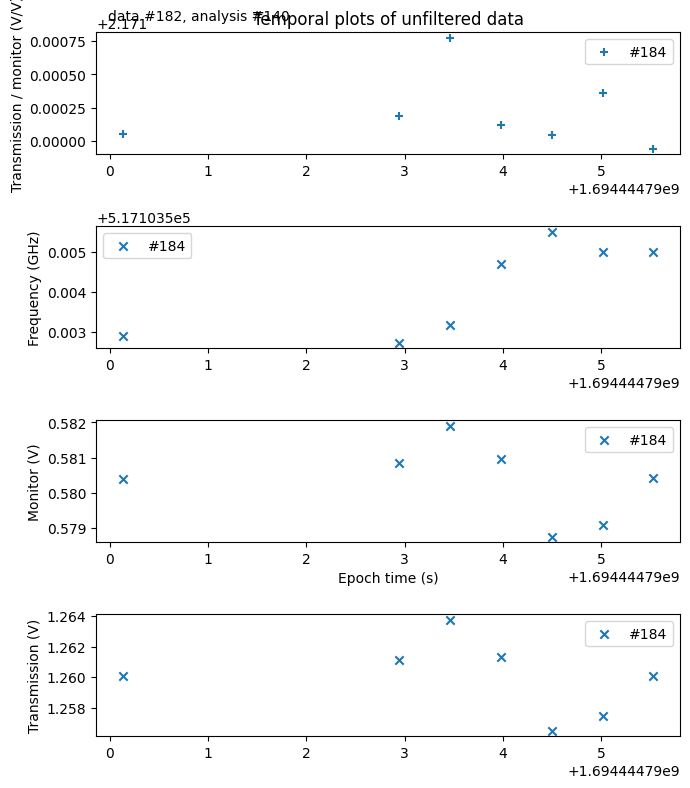

In [662]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(7, 8))
add_label(ax)
ax2.set_xlabel("Epoch time (s)")
ax.set_ylabel("Transmission / monitor (V/V)")
ax1.set_ylabel("Frequency (GHz)")
ax2.set_ylabel("Monitor (V)")
ax3.set_ylabel("Transmission (V)")
ax.set_title("Temporal plots of unfiltered data")
f_min = np.infty
f_max = -np.infty
for kk in data_numbers:
    run = data[kk]
    ax.scatter(run.time, run.V_ratio, marker="+", label=f"#{kk}")
    ax1.scatter(run.time, run.frequency_GHz, marker="x", label=f"#{kk}")
    ax2.scatter(run.time, run.V_monitor, marker="x", label=f"#{kk}")
    ax3.scatter(run.time, run.V_transmission, marker="x", label=f"#{kk}")
    if run.valid_frequency_range_GHz[0] < f_min:
        f_min = run.valid_frequency_range_GHz[0]
    if run.valid_frequency_range_GHz[1] > f_max:
        f_max = run.valid_frequency_range_GHz[1]
spacing = 0.05 * (f_max - f_min)
f_min -= spacing
f_max += spacing
ax1.set_ylim(f_min, f_max)
# ax.set_ylim(1.993, 1.998)
# ax2.set_ylim(0.3, 0.35)
# ax3.set_ylim(0.6, 0.7)

ax.legend()
ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()

plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_temporal.pdf")
)

plt.show()

## V_ratio plot

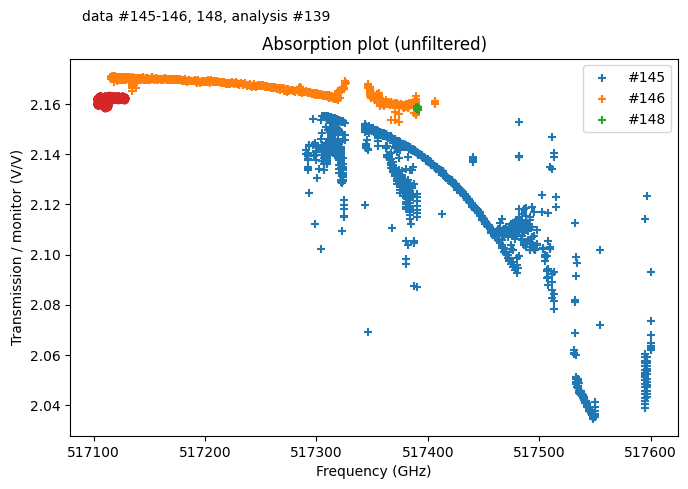

In [650]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (unfiltered)")
for kk in data_numbers:
    run = data[kk]
    ax.scatter(
        run.frequency_GHz[run.valid_freq_mask],
        run.V_ratio[run.valid_freq_mask],
        marker="+",label=f"#{kk}"
    )

data_temp = [[517103.885, 5.78019, 2.67597, 8.456, 2.1600], [517103.886, 5.72315, 2.64958, 8.373, 2.1600], [517103.886, 5.66565, 2.62307, 8.289, 2.1599], [517103.885, 5.59559, 2.59067, 8.186, 2.1599], [517103.885, 5.53054, 2.56047, 8.091, 2.1600], [517103.885, 5.49157, 2.54235, 8.034, 2.1600], [517103.884, 5.43620, 2.51685, 7.953, 2.1599], [517103.884, 5.37128, 2.48673, 7.858, 2.1600], [517103.884, 5.30440, 2.45579, 7.760, 2.1600], [517103.884, 5.24591, 2.42859, 7.675, 2.1601], [517103.885, 5.18600, 2.40088, 7.587, 2.1600], [517103.884, 5.13346, 2.37657, 7.510, 2.1600], [517103.884, 5.07748, 2.35049, 7.428, 2.1602], [517103.883, 5.01319, 2.32083, 7.334, 2.1601], [517103.883, 4.95310, 2.29299, 7.246, 2.1601], [517103.883, 4.87387, 2.25632, 7.130, 2.1601], [517103.883, 4.78645, 2.21576, 7.002, 2.1602], [517103.883, 4.97721, 2.30389, 7.281, 2.1603], [517103.841, 5.87267, 2.71646, 8.589, 2.1619], [517103.841, 5.84487, 2.70353, 8.548, 2.1619], [517103.832, 5.82737, 2.69541, 8.523, 2.1620], [517103.832, 5.82410, 2.69387, 8.518, 2.1620], [517103.831, 5.79243, 2.67931, 8.472, 2.1619], [517103.831, 5.73247, 2.65157, 8.384, 2.1619], [517103.830, 5.66193, 2.61901, 8.281, 2.1619], [517103.828, 5.61670, 2.59802, 8.215, 2.1619], [517103.828, 5.57627, 2.57926, 8.156, 2.1620], [517103.825, 5.52364, 2.55484, 8.078, 2.1620], [517103.825, 5.48529, 2.53706, 8.022, 2.1621], [517103.826, 5.46931, 2.52968, 7.999, 2.1621], [517103.826, 5.44895, 2.52015, 7.969, 2.1622], [517103.827, 5.41666, 2.50532, 7.922, 2.1621], [517103.827, 5.37917, 2.48792, 7.867, 2.1621], [517103.826, 5.34774, 2.47333, 7.821, 2.1622], [517103.824, 5.32991, 2.46508, 7.795, 2.1622], [517103.824, 5.53975, 2.56253, 8.102, 2.1619], [517103.822, 6.14391, 2.84299, 8.987, 2.1611], [517103.822, 6.07980, 2.81337, 8.893, 2.1610], [517105.563, 6.04888, 2.79905, 8.848, 2.1611], [517105.564, 5.97496, 2.76497, 8.740, 2.1609], [517105.564, 5.92530, 2.74198, 8.667, 2.1610], [517105.564, 5.86495, 2.71383, 8.579, 2.1611], [517105.564, 5.79903, 2.68350, 8.483, 2.1610], [517105.564, 5.72727, 2.65026, 8.378, 2.1610], [517105.564, 5.62605, 2.60348, 8.230, 2.1610], [517105.564, 5.52718, 2.55768, 8.085, 2.1610], [517105.564, 5.44263, 2.51849, 7.961, 2.1611], [517105.564, 5.35492, 2.47786, 7.833, 2.1611], [517105.564, 5.26162, 2.43474, 7.696, 2.1611], [517105.564, 5.16032, 2.38783, 7.548, 2.1611], [517105.563, 5.09937, 2.35950, 7.459, 2.1612], [517105.563, 5.04863, 2.33615, 7.385, 2.1611], [517105.561, 4.98672, 2.30748, 7.294, 2.1611], [517105.558, 4.90255, 2.26850, 7.171, 2.1611], [517105.558, 6.34146, 2.93220, 9.274, 2.1627], [517105.502, 6.31014, 2.91754, 9.228, 2.1628], [517105.502, 6.28577, 2.90633, 9.192, 2.1628], [517105.498, 6.27376, 2.90082, 9.175, 2.1628], [517105.498, 6.21733, 2.87470, 9.092, 2.1628], [517105.497, 6.23231, 2.88165, 9.114, 2.1628], [517105.496, 6.17589, 2.85560, 9.031, 2.1627], [517105.496, 6.12226, 2.83087, 8.953, 2.1627], [517105.497, 6.10308, 2.82200, 8.925, 2.1627], [517105.497, 6.08204, 2.81222, 8.894, 2.1627], [517105.497, 6.06914, 2.80619, 8.875, 2.1628], [517105.497, 6.05554, 2.80003, 8.856, 2.1627], [517105.496, 6.02590, 2.78637, 8.812, 2.1626], [517105.495, 5.96079, 2.75635, 8.717, 2.1626], [517105.495, 5.91296, 2.73434, 8.647, 2.1625], [517105.494, 5.88609, 2.72186, 8.608, 2.1625], [517105.494, 5.86521, 2.71199, 8.577, 2.1627], [517105.491, 5.82367, 2.69286, 8.517, 2.1626], [517105.491, 5.71271, 2.64460, 8.357, 2.1601], [517107.231, 5.65020, 2.61564, 8.266, 2.1602], [517107.242, 5.55666, 2.57242, 8.129, 2.1601], [517107.242, 5.50372, 2.54764, 8.051, 2.1603], [517107.242, 5.43532, 2.51592, 7.951, 2.1604], [517107.242, 5.35861, 2.48033, 7.839, 2.1604], [517107.242, 5.30624, 2.45614, 7.762, 2.1604], [517107.242, 5.21158, 2.41214, 7.624, 2.1606], [517107.241, 5.15739, 2.38710, 7.544, 2.1605], [517107.239, 5.08092, 2.35169, 7.433, 2.1605], [517107.239, 4.98359, 2.30662, 7.290, 2.1606], [517107.237, 4.86430, 2.25149, 7.116, 2.1605], [517107.237, 5.74380, 2.65665, 8.400, 2.1620], [517107.187, 5.99108, 2.77043, 8.762, 2.1625], [517107.187, 5.95822, 2.75538, 8.714, 2.1624], [517107.167, 5.90483, 2.73067, 8.636, 2.1624], [517107.165, 5.85068, 2.70557, 8.556, 2.1625], [517107.165, 5.85698, 2.70845, 8.565, 2.1625], [517107.163, 5.82896, 2.69554, 8.525, 2.1624], [517107.163, 5.72742, 2.64873, 8.376, 2.1623], [517107.162, 5.69674, 2.63453, 8.331, 2.1623], [517107.162, 5.69098, 2.63194, 8.323, 2.1623], [517107.161, 5.68380, 2.62855, 8.312, 2.1623], [517107.159, 5.62972, 2.60345, 8.233, 2.1624], [517107.159, 5.57982, 2.58028, 8.160, 2.1625], 
             [517107.157, 5.52767, 2.55621, 8.084, 2.1624], [517107.157, 5.48051, 2.53444, 8.015, 2.1624], [517107.157, 5.40215, 2.49816, 7.900, 2.1624], [517107.157, 5.40344, 2.49872, 7.902, 2.1625], [517107.156, 5.40163, 2.49785, 7.899, 2.1625], [517107.154, 5.61604, 2.59750, 8.214, 2.1621], [517107.154, 6.03150, 2.79059, 8.822, 2.1614], [517108.917, 5.94902, 2.75264, 8.702, 2.1612], [517108.917, 5.86462, 2.71357, 8.578, 2.1612], [517108.920, 5.77559, 2.67244, 8.448, 2.1612], [517108.920, 5.62864, 2.60451, 8.233, 2.1611], [517108.918, 5.57587, 2.58007, 8.156, 2.1611], [517108.914, 5.43086, 2.51290, 7.944, 2.1612], [517108.914, 5.55062, 2.56803, 8.119, 2.1614], [517108.912, 6.81313, 3.15072, 9.964, 2.1624], [517108.912, 6.78858, 3.13940, 9.928, 2.1624], [517108.830, 6.73536, 3.11483, 9.850, 2.1624], [517108.830, 6.63300, 3.06742, 9.700, 2.1624], [517108.829, 6.54765, 3.02798, 9.576, 2.1624], [517108.830, 6.48857, 3.00059, 9.489, 2.1624], [517108.830, 6.39628, 2.95788, 9.354, 2.1625], [517108.830, 6.31642, 2.92098, 9.237, 2.1624], [517108.830, 6.26710, 2.89807, 9.165, 2.1625], [517108.830, 6.21286, 2.87308, 9.086, 2.1624], [517108.829, 6.15690, 2.84726, 9.004, 2.1624], [517108.829, 6.08005, 2.81172, 8.892, 2.1624], [517108.827, 5.97776, 2.76448, 8.742, 2.1623], [517108.827, 5.91956, 2.73770, 8.657, 2.1622], [517108.824, 5.89471, 2.72629, 8.621, 2.1622], [517108.824, 5.84481, 2.70300, 8.548, 2.1623], [517108.820, 5.79438, 2.67985, 8.474, 2.1622], [517108.818, 5.73133, 2.65074, 8.382, 2.1622], [517108.818, 4.37993, 2.02744, 6.407, 2.1603], [517110.639, 4.22247, 1.95483, 6.177, 2.1600], [517110.639, 4.10285, 1.89959, 6.002, 2.1599], [517110.653, 3.98938, 1.84717, 5.837, 2.1597], [517110.653, 3.96560, 1.83642, 5.802, 2.1594], [517110.660, 4.05534, 1.87804, 5.933, 2.1594], [517110.673, 4.18458, 1.93789, 6.122, 2.1594], [517110.673, 4.29602, 1.98950, 6.286, 2.1593], [517110.680, 4.21340, 1.95141, 6.165, 2.1592], [517110.680, 4.11681, 1.90661, 6.023, 2.1592], [517110.682, 4.01317, 1.85868, 5.872, 2.1592], [517110.682, 3.90296, 1.80776, 5.711, 2.1590], [517110.684, 3.75553, 1.73960, 5.495, 2.1588], [517110.685, 4.11878, 1.90716, 6.026, 2.1593], [517110.685, 6.10197, 2.82112, 8.923, 2.1630], [517110.504, 6.08733, 2.81445, 8.902, 2.1629], [517110.504, 6.06939, 2.80609, 8.875, 2.1629], [517110.491, 5.99887, 2.77354, 8.772, 2.1629], [517110.491, 5.96842, 2.75940, 8.728, 2.1629], [517110.484, 5.95277, 2.75221, 8.705, 2.1629], [517110.477, 5.30062, 2.45200, 7.753, 2.1616], [517110.477, 4.76787, 2.20741, 6.975, 2.1599], [517110.477, 4.67004, 2.16233, 6.832, 2.1597], [517110.477, 4.55137, 2.10748, 6.659, 2.1596], [517112.386, 4.43658, 2.05443, 6.491, 2.1595], [517112.389, 4.29355, 1.98821, 6.282, 2.1595], [517112.389, 4.18017, 1.93584, 6.116, 2.1594], [517112.392, 4.08855, 1.89337, 5.982, 2.1594], [517112.392, 3.94721, 1.82808, 5.775, 2.1592], [517112.395, 5.61531, 2.59783, 8.213, 2.1613], [517112.395, 6.10503, 2.82364, 8.929, 2.1621], [517112.173, 6.04578, 2.79627, 8.842, 2.1621], [517112.160, 5.97236, 2.76228, 8.735, 2.1621], [517112.160, 5.86571, 2.71293, 8.579, 2.1621], [517112.159, 5.78987, 2.67792, 8.468, 2.1621], [517112.159, 5.72528, 2.64804, 8.373, 2.1621], [517112.158, 5.67080, 2.62287, 8.294, 2.1621], [517112.158, 5.62895, 2.60349, 8.232, 2.1621], [517112.154, 5.57462, 2.57823, 8.153, 2.1622], [517112.147, 5.52794, 2.55674, 8.085, 2.1621], [517112.147, 5.17335, 2.39297, 7.566, 2.1619], [517114.028, 4.76086, 2.20298, 6.964, 2.1611], [517114.028, 5.26268, 2.43462, 7.697, 2.1615], [517114.082, 7.26842, 3.36027, 10.629, 2.1630], [517114.082, 7.19403, 3.32584, 10.520, 2.1631], [517113.832, 7.10898, 3.28661, 10.396, 2.1630], [517113.829, 7.02663, 3.24861, 10.275, 2.1630], [517113.829, 6.94618, 3.21135, 10.158, 2.1630], [517113.828, 6.84699, 3.16565, 10.013, 2.1629], [517113.828, 6.75431, 3.12270, 9.877, 2.1630], [517113.829, 6.68829, 3.09218, 9.780, 2.1630], [517113.829, 6.67639, 3.08683, 9.763, 2.1629], [517113.829, 6.63723, 3.06870, 9.706, 2.1629], [517113.829, 6.57664, 3.04071, 9.617, 2.1629], [517113.829, 6.51149, 3.01065, 9.522, 2.1628], [517113.828, 6.45855, 2.98595, 9.444, 2.1630], [517113.828, 6.42229, 2.96909, 9.391, 2.1630], [517113.824, 6.39371, 2.95588, 9.350, 2.1630], [517113.824, 5.87862, 2.71782, 8.596, 2.1630], [517113.816, 4.55345, 2.10563, 6.659, 2.1625], [517113.816, 4.60002, 2.12731, 6.727, 2.1624], [517115.510, 6.56616, 3.03652, 9.603, 2.1624], [517115.502, 6.51650, 3.01373, 9.530, 2.1623], [517115.502, 6.55462, 3.03130, 9.586, 2.1623], [517115.499, 6.45328, 2.98419, 9.437, 2.1625], 
             [517115.499, 6.35314, 2.93796, 9.291, 2.1624], [517115.499, 6.25156, 2.89084, 9.142, 2.1625], [517115.499, 6.19066, 2.86271, 9.053, 2.1625], [517115.497, 6.10227, 2.82187, 8.924, 2.1625], [517115.496, 6.05000, 2.79764, 8.848, 2.1625], [517115.496, 6.03261, 2.78960, 8.822, 2.1625], [517115.493, 5.96445, 2.75808, 8.723, 2.1625], [517115.493, 5.90000, 2.72848, 8.628, 2.1624], [517115.490, 5.83947, 2.70034, 8.540, 2.1625], [517115.490, 5.79744, 2.68094, 8.478, 2.1625], [517115.485, 5.77709, 2.67163, 8.449, 2.1624], [517115.476, 4.98737, 2.30612, 7.293, 2.1627], [517115.476, 4.84775, 2.24167, 7.089, 2.1626], [517117.172, 5.35195, 2.47505, 7.827, 2.1624], [517117.172, 7.29815, 3.37460, 10.673, 2.1627], [517117.168, 7.20424, 3.33115, 10.535, 2.1627], [517117.168, 7.11229, 3.28865, 10.401, 2.1627], [517117.169, 7.01804, 3.24506, 10.263, 2.1627], 
             [517117.167, 6.91915, 3.19928, 10.118, 2.1627], [517117.167, 6.82743, 3.15707, 9.985, 2.1626], [517117.164, 6.73138, 3.11283, 9.844, 2.1625], [517117.164, 6.64606, 3.07326, 9.719, 2.1625], [517117.162, 6.55813, 3.03259, 9.591, 2.1626], [517117.162, 6.48448, 2.99830, 9.483, 2.1627], [517117.159, 6.40040, 2.95943, 9.360, 2.1627], [517117.159, 6.30382, 2.91495, 9.219, 2.1626], [517117.155, 6.20625, 2.86989, 9.076, 2.1625], [517117.151, 6.11244, 2.82652, 8.939, 2.1625], [517117.151, 6.04760, 2.79639, 8.844, 2.1626], [517117.144, 5.07853, 2.34823, 7.427, 2.1627], [517117.144, 4.65147, 2.15104, 6.803, 2.1624], [517118.840, 6.78544, 3.13789, 9.923, 2.1624], [517118.840, 6.88290, 3.18275, 10.066, 2.1626], [517118.834, 6.80923, 3.14875, 9.958, 2.1625], [517118.833, 6.73983, 3.11673, 9.857, 2.1625], [517118.833, 6.70156, 3.09901, 9.801, 2.1625], [517118.834, 6.63122, 3.06635, 9.698, 2.1626], 
             [517118.834, 6.57000, 3.03813, 9.608, 2.1625], [517118.832, 6.52272, 3.01629, 9.539, 2.1625], [517118.832, 6.44972, 2.98220, 9.432, 2.1627], [517118.832, 6.39724, 2.95787, 9.355, 2.1628], [517118.831, 6.38710, 2.95317, 9.340, 2.1628], [517118.831, 6.36629, 2.94372, 9.310, 2.1627], [517118.827, 6.32760, 2.92584, 9.253, 2.1627], [517118.827, 6.26132, 2.89525, 9.157, 2.1626], [517118.821, 5.80031, 2.68207, 8.482, 2.1626], [517118.821, 4.69932, 2.17331, 6.873, 2.1623], [517120.517, 5.67935, 2.62656, 8.306, 2.1623], [517120.510, 7.03301, 3.25235, 10.285, 2.1624], [517120.510, 6.97323, 3.22463, 10.198, 2.1625], [517120.509, 6.89285, 3.18762, 10.080, 2.1624], [517120.509, 6.77981, 3.13538, 9.915, 2.1624], [517120.507, 6.63626, 3.06897, 9.705, 2.1624], [517120.507, 6.48398, 2.99856, 9.483, 2.1624], [517120.504, 6.41608, 2.96710, 9.383, 2.1624], [517120.501, 6.32023, 2.92291, 9.243, 2.1623], [517120.501, 6.25592, 2.89304, 9.149, 2.1624], [517120.497, 6.18559, 2.86058, 9.046, 2.1624], [517120.497, 6.09360, 2.81801, 8.912, 2.1624], [517120.493, 5.99920, 2.77445, 8.774, 2.1623], [517120.493, 5.91969, 2.73772, 8.657, 2.1623], [517120.486, 5.85773, 2.70893, 8.567, 2.1624], [517122.184, 4.96620, 2.29650, 7.263, 2.1625], [517122.184, 6.08918, 2.81599, 8.905, 2.1624], [517122.172, 7.57025, 3.50026, 11.071, 2.1628], 
             [517122.172, 7.41402, 3.42805, 10.842, 2.1628], [517122.174, 7.27923, 3.36586, 10.645, 2.1627], [517122.174, 7.23307, 3.34442, 10.577, 2.1627], [517122.173, 7.16010, 3.31058, 10.471, 2.1628], [517122.172, 7.06025, 3.26458, 10.325, 2.1627], [517122.172, 6.97534, 3.22524, 10.201, 2.1627], [517122.173, 6.88497, 3.18350, 10.068, 2.1627], [517122.173, 6.80523, 3.14684, 9.952, 2.1626], [517122.170, 6.73253, 3.11321, 9.846, 2.1626], [517122.170, 6.68405, 3.09079, 9.775, 2.1626], [517122.167, 6.66650, 3.08265, 9.749, 2.1626], [517122.159, 5.84831, 2.70429, 8.553, 2.1626], [517122.159, 4.79967, 2.21991, 7.020, 2.1621], [517123.849, 6.90011, 3.19088, 10.091, 2.1624], [517123.849, 6.76220, 3.12723, 9.889, 2.1624], [517123.846, 6.67227, 3.08566, 9.758, 2.1623], [517123.846, 6.58356, 3.04460, 9.628, 2.1624], [517123.846, 6.45731, 2.98604, 9.443, 2.1625], [517123.843, 6.38350, 2.95188, 9.335, 2.1625], [517123.843, 6.33452, 2.92931, 9.264, 2.1625], [517123.839, 6.27444, 2.90144, 9.176, 2.1625], [517123.839, 6.19884, 2.86658, 9.065, 2.1625], [517123.834, 6.11411, 2.82736, 8.941, 2.1625], [517123.834, 6.06298, 2.80370, 8.867, 2.1625], [517123.828, 6.05799, 2.80136, 8.859, 2.1625], [517123.828, 4.91633, 2.27344, 7.190, 2.1625], [517125.522, 7.12116, 3.29310, 10.414, 2.1624], [517125.518, 7.44028, 3.44037, 10.881, 2.1626], 
             [517125.518, 7.27513, 3.36395, 10.639, 2.1627], [517125.520, 7.13993, 3.30142, 10.441, 2.1627], [517125.520, 7.01119, 3.24187, 10.253, 2.1627], [517125.519, 6.87654, 3.17977, 10.056, 2.1626], [517125.519, 6.74816, 3.12055, 9.869, 2.1625], [517125.518, 6.64785, 3.07415, 9.722, 2.1625], [517125.517, 6.56716, 3.03674, 9.604, 2.1626], [517125.517, 6.48665, 2.99943, 9.486, 2.1626], [517125.510, 6.37988, 2.95003, 9.330, 2.1626], [517125.510, 5.73928, 2.65359, 8.393, 2.1629], [517125.499, 5.81297, 2.68828, 8.501, 2.1624], [517125.499, 7.16994, 3.31557, 10.486, 2.1625], [517127.194, 7.08060, 3.27419, 10.355, 2.1626], [517127.194, 7.02275, 3.24751, 10.270, 2.1625], [517127.194, 6.92925, 3.20437, 10.134, 2.1624], [517127.193, 6.85352, 3.16943, 10.023, 2.1624], [517127.193, 6.78642, 3.13844, 9.925, 2.1624], [517127.191, 6.75690, 3.12476, 9.882, 2.1624], [517127.191, 6.70653, 3.10160, 9.808, 2.1623], [517127.187, 6.64073, 3.07126, 9.712, 2.1622], [517127.180, 6.61640, 3.06005, 9.676, 2.1622]]
data_temp_T = np.transpose(data_temp)
ax.scatter(data_temp_T[0], data_temp_T[-1])
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_unfiltered_V_ratio.pdf")
)
plt.show()

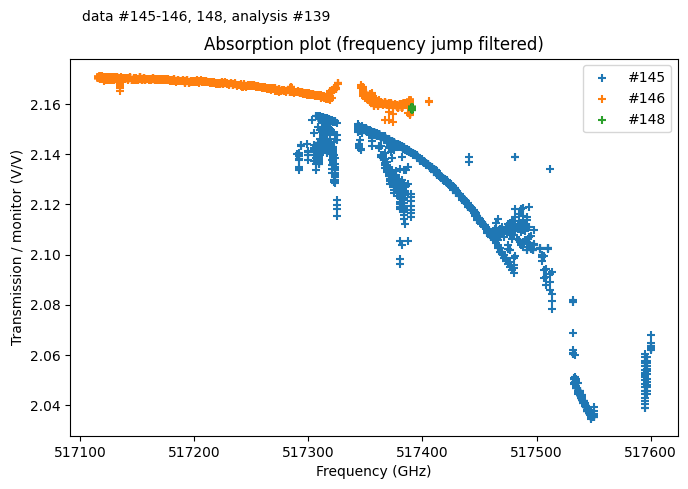

In [651]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered)")
for kk in data_numbers:
    run = data[kk]
    ax.scatter(
        run.frequency_GHz[run.frequency_jump_mask],
        run.V_ratio[run.frequency_jump_mask],
        marker="+",label=f"#{kk}"
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_jump_filtered_V_ratio.pdf")
)
plt.show()

## Binned plot

/tmp/ipykernel_828243/4060335712.py:61: RuntimeWarning: invalid value encountered in divide
  self.V_ratio_binned_err = stds / np.sqrt(occurrences)
/tmp/ipykernel_828243/4060335712.py:61: RuntimeWarning: invalid value encountered in divide
  self.V_ratio_binned_err = stds / np.sqrt(occurrences)


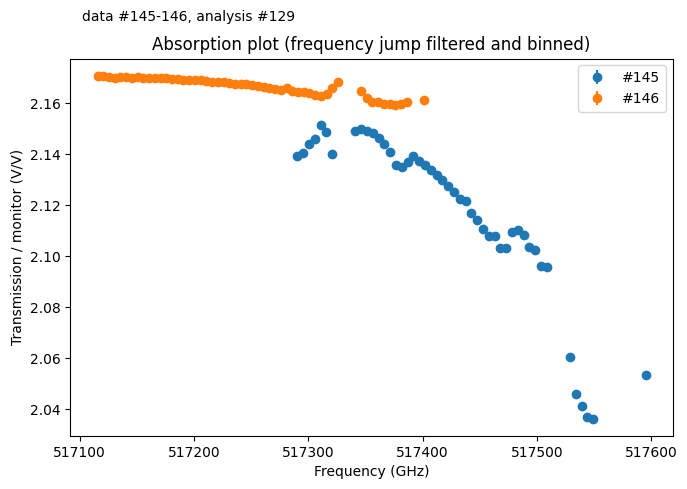

In [609]:
bin_width_GHz = 5
for kk in data_numbers:
    data[kk].bin_data(bin_width_GHz)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered and binned)")
for kk in data_numbers:
    run = data[kk]
    ax.errorbar(
        run.frequency_binned,
        run.V_ratio_binned_avg,
        run.V_ratio_binned_err,
        marker="o", label=f"#{kk}", ls="none",
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_binned_V_ratio.pdf")
)
plt.show()


## Multiple Samples

In [397]:
def average_error(error_array):
    try:
        error = np.div(1, np.sum(np.divide(1, np.power(error_array, 2))))
    except:
        error = 0
    return error

def weight_average(data_array):
    try:
        mean = np.div(1, np.sum(np.divide(1, np.power(error_array, 2))))
    except:
        error = 0
    return error

data_numbers = [50, 51, 52, 53, 54]

In [398]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

KeyboardInterrupt: Interrupted by user

96
97
98
99
100
102
219


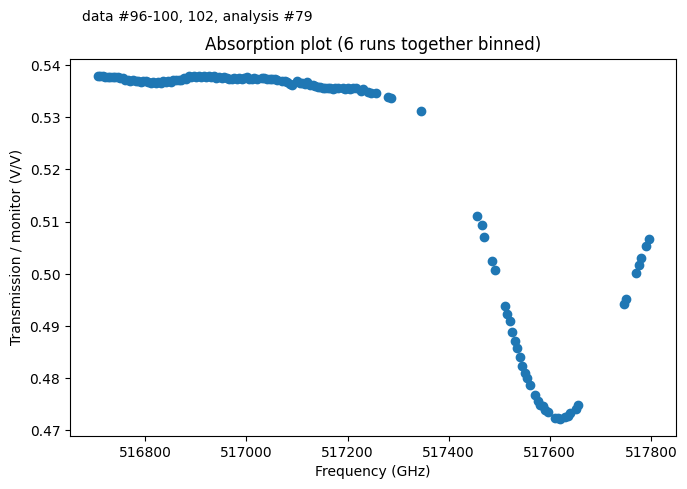

In [247]:
class MultipleTransmissionRuns:
    """ A class that takes multiple transmission runs and connects them into one data set to do analysis.
    """
    num_transmission_runs: int
    V_ratio: np.ndarray
    V_ratio_err: np.ndarray
    frequency: np.ndarray
    V_ratio_binned_avg: np.ndarray
    V_ratio_binned_err: np.ndarray
    frequency_binned: np.ndarray
    
    def __init__(self, list_data_numbers, frequency_jump_threshold_GHz=3, bin_width_GHz=5):
        self.num_transmission_runs = len(list_data_numbers)
        data = dict([(
            kk,
            TransmissionRun(get_experiment_data(kk), frequency_jump_threshold_GHz)
            ) for kk in data_numbers])        
    
        self.V_ratio = np.array([])
        self.V_ratio_err = np.array([])
        self.frequency = np.array([])
        for kk in data_numbers:
            run = data[kk]
            print(kk)
            self.frequency = np.concatenate((self.frequency, run.frequency_GHz[run.frequency_jump_mask]))
            self.V_ratio = np.concatenate((self.V_ratio, run.V_ratio[run.frequency_jump_mask]))
            self.V_ratio_err = np.concatenate((self.V_ratio, run.frequency_GHz[run.frequency_jump_mask]))
        
        self._rebin_data(bin_width_GHz)
        
            
    def _rebin_data(self, bin_width_GHz):
        num_bins = int((self.frequency_binned.max() - self.frequency_binned.min()) / bin_width_GHz)
        print(num_bins)
        if num_bins == 0:
            num_bins = 1
        
        means, bin_edges, binnumber = st.binned_statistic(
            self.frequency_binned, self.V_ratio_binned_avg, statistic="mean", bins=num_bins
        )
        error, bin_edges, binnumber = st.binned_statistic(
            self.frequency_binned, self.V_ratio_binned_err, statistic="std", bins=num_bins
        )
        
        occurrences = np.bincount(binnumber)[1:]
        self.V_ratio_rebinned_avg = means
        self.V_ratio_rebinned_err = error
        self.frequency_rebinned = bin_edges[1:] - bin_edges[1] + bin_edges[0]
    
    def plot_runs(self):
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        add_label(ax)
        ax.set_ylabel("Transmission / monitor (V/V)")
        ax.set_xlabel("Frequency (GHz)")
        ax.set_title(f"Absorption plot ({self.num_transmission_runs} runs together binned)")
        ax.errorbar(
            self.frequency_rebinned,
            self.V_ratio_rebinned_avg,
            self.V_ratio_rebinned_err,
            marker="o", ls="none",
        )
        plt.tight_layout()
        plt.show()
        
test_multiple = MultipleTransmissionRuns(data_numbers)
test_multiple.plot_runs()

## Optical depth

In [ ]:
transmission_norm = transmission/normalization
normalized_transmission_errs = np.sqrt((trans_err/transmission)**2 + (power_err/power)**2) * transmission_norm

y = -np.log(np.array(transmission_norm))
y_err = normalized_transmission_errs/transmission_norm

plt.errorbar(freq, y, yerr=y_err, marker='.', linestyle='')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Optical Depth")
plt.ylim(0, )
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_absorption_optical_depth.pdf")
)
plt.show()

## Fitting

In [ ]:
def gaussian(x, a, b, c, d):
    return a * np.exp(-(1/2)*((x-b)/c)**2) + d

def lorentzian(x, a, b, c, d):
    return a / (np.pi) * (c / ((x-b)**2 + c**2)) + d